## Figure 2

Percent matching for Cell Painting and L1000

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure2")
extensions <- c(".png", ".pdf")

### Panel A - Percent matching within assay

In [3]:
results_dir <- file.path("../1.Data-exploration/Consensus/")

In [4]:
pm_cellpainting_list <- load_percent_matching(assay = "cellpainting", results_dir = results_dir)
pm_l1000_list <- load_percent_matching(assay = "l1000", results_dir = results_dir)

print(dim(pm_cellpainting_list[["percent_matching"]]))
print(dim(pm_l1000_list[["percent_matching"]]))

print(dim(pm_cellpainting_list[["percent_matching_pvals"]]))
print(dim(pm_l1000_list[["percent_matching_pvals"]]))

[1] 1266    5
[1] 1266    5
[1] 1266    5
[1] 1266    5


In [5]:
p_val_alpha_thresh <- 0.05
plot_thresh <- -log10(p_val_alpha_thresh)

no_replicates_thresh <- 3

cell_painting_pm_df <- pm_cellpainting_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_df <- pm_l1000_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_df <- dplyr::bind_rows(cell_painting_pm_df, l1000_pm_df)

cell_painting_pm_pval_df <- pm_cellpainting_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_pval_df <- pm_l1000_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_pval_df <- dplyr::bind_rows(cell_painting_pm_pval_df, l1000_pm_pval_df)

pm_df <- pm_df %>%
    dplyr::left_join(pm_pval_df, by = c("moa", "dose", "assay", "no_of_replicates")) %>%
    dplyr::mutate(pass_thresh = p_value < p_val_alpha_thresh) %>%
    dplyr::mutate(neg_log_10_p_val = -log10(p_value))

pm_df$dose <- factor(pm_df$dose, levels = dose_order)

pm_df$neg_log_10_p_val[pm_df$neg_log_10_p_val == Inf] = 3.5

print(dim(pm_df))
head(pm_df)

[1] 1524    8


moa,no_of_replicates,dose,matching_score,assay,p_value,pass_thresh,neg_log_10_p_val
<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>
acat inhibitor,3,0.04 uM,0.004444607,Cell Painting,0.534,FALSE,0.2724587
acetylcholine receptor agonist,8,0.04 uM,0.005142343,Cell Painting,0.598,FALSE,0.2232988
acetylcholine receptor antagonist,21,0.04 uM,0.019262183,Cell Painting,0.019,TRUE,1.7212464
adenosine receptor agonist,3,0.04 uM,0.009583710,Cell Painting,0.459,FALSE,0.3381873
adenosine receptor antagonist,4,0.04 uM,0.001703919,Cell Painting,0.621,FALSE,0.2069084
adrenergic receptor agonist,20,0.04 uM,0.005015938,Cell Painting,0.666,FALSE,0.1765258


In [6]:
percent_matching_df <- pm_df %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::mutate(percent_matching = paste0(100 * round((sum(pass_thresh) / length(pass_thresh)), 2), "%")) %>%
    dplyr::select(dose, assay, percent_matching) %>%
    dplyr::distinct()

percent_matching_df

dose,assay,percent_matching
<fct>,<chr>,<chr>
0.04 uM,Cell Painting,16%
0.12 uM,Cell Painting,17%
0.37 uM,Cell Painting,19%
1.11 uM,Cell Painting,24%
3.33 uM,Cell Painting,26%
10 uM,Cell Painting,29%
0.04 uM,L1000,7%
0.12 uM,L1000,9%
0.37 uM,L1000,15%


In [7]:
# How many compounds per assay per dose with greater than 3 compounds?
for (dose in unique(pm_df$dose)) {
    pm_sub_df <- pm_df %>% dplyr::filter(dose == !!dose)
    print(table(pm_sub_df %>% dplyr::pull(assay)))
}


Cell Painting         L1000 
          127           127 

Cell Painting         L1000 
          127           127 

Cell Painting         L1000 
          127           127 

Cell Painting         L1000 
          127           127 

Cell Painting         L1000 
          127           127 

Cell Painting         L1000 
          127           127 


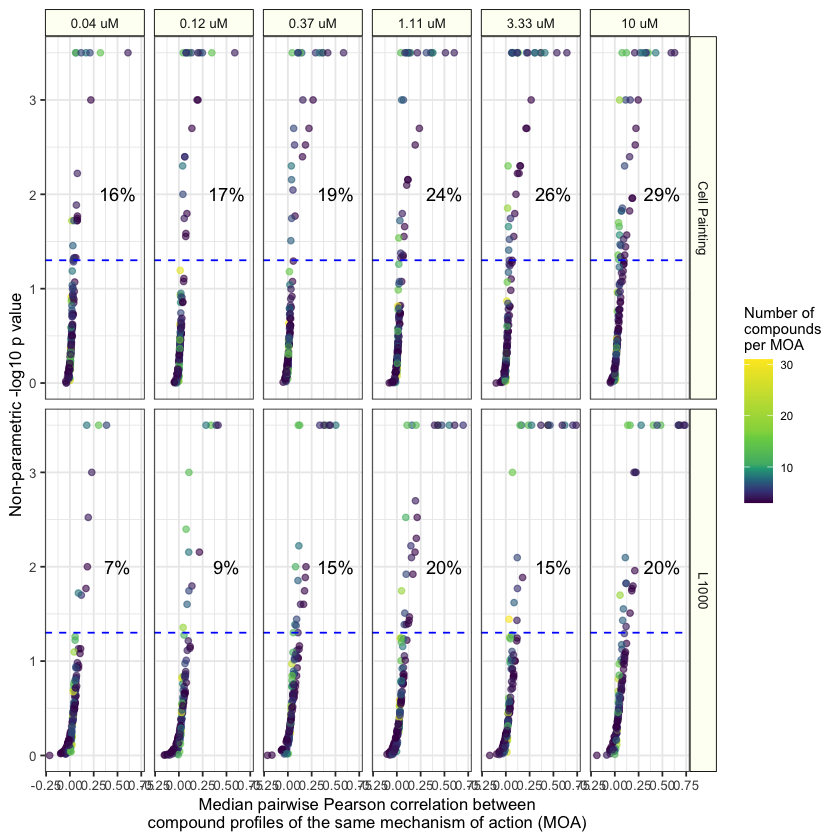

In [8]:
panel_a_gg <- (
    ggplot(pm_df, aes(x = matching_score, y = neg_log_10_p_val))
    + geom_point(aes(color = no_of_replicates), alpha = 0.6)
    + geom_text(data = percent_matching_df, aes(label = percent_matching, x = 0.5, y = 2))
    + facet_grid("assay~dose")
    + geom_hline(linetype = "dashed", color = "blue", yintercept = plot_thresh)
    + theme_bw()
    + figure_theme
    + scale_color_continuous("Number of\ncompounds\nper MOA", values = scales::rescale(c(0, 2, 4, 6, 8, 15, 30)), type = "viridis")
    + xlab("Median pairwise Pearson correlation between\ncompound profiles of the same mechanism of action (MOA)")
    + ylab("Non-parametric -log10 p value")
)

panel_a_gg

## Panel B - MOA median correlation comparison between assays

In [9]:
results_dir <- file.path("../1.Data-exploration/Consensus/")

pm_cellpainting_list <- load_percent_matching(assay = "cellpainting", results_dir = results_dir)
pm_l1000_list <- load_percent_matching(assay = "l1000", results_dir = results_dir)

cell_painting_pm_df <- pm_cellpainting_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_df <- pm_l1000_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_df <- dplyr::bind_rows(cell_painting_pm_df, l1000_pm_df)

cell_painting_pm_pval_df <- pm_cellpainting_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_pval_df <- pm_l1000_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_pval_df <- dplyr::bind_rows(cell_painting_pm_pval_df, l1000_pm_pval_df)

pm_df <- pm_df %>%
    dplyr::left_join(pm_pval_df, by = c("moa", "dose", "assay", "no_of_replicates")) %>%
    dplyr::mutate(pass_thresh = p_value < p_val_alpha_thresh) %>%
    dplyr::mutate(neg_log_10_p_val = -log10(p_value))

pm_df$dose <- factor(pm_df$dose, levels = dose_order)

pm_df$neg_log_10_p_val[pm_df$neg_log_10_p_val == Inf] = 3.5

print(dim(pm_df))
head(pm_df)

[1] 1524    8


moa,no_of_replicates,dose,matching_score,assay,p_value,pass_thresh,neg_log_10_p_val
<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>
acat inhibitor,3,0.04 uM,0.004444607,Cell Painting,0.534,FALSE,0.2724587
acetylcholine receptor agonist,8,0.04 uM,0.005142343,Cell Painting,0.598,FALSE,0.2232988
acetylcholine receptor antagonist,21,0.04 uM,0.019262183,Cell Painting,0.019,TRUE,1.7212464
adenosine receptor agonist,3,0.04 uM,0.009583710,Cell Painting,0.459,FALSE,0.3381873
adenosine receptor antagonist,4,0.04 uM,0.001703919,Cell Painting,0.621,FALSE,0.2069084
adrenergic receptor agonist,20,0.04 uM,0.005015938,Cell Painting,0.666,FALSE,0.1765258


In [10]:
# Prep additional data for plotting
replicate_counts_df <- pm_df %>%
    tidyr::drop_na() %>%
    dplyr::group_by(moa, dose) %>%
    dplyr::mutate(avg_replicate_count = mean(no_of_replicates)) %>%
    dplyr::select(moa, dose, avg_replicate_count) %>%
    dplyr::ungroup() %>%
    dplyr::distinct()

cp_pass_thresh <- pm_df %>%
    dplyr::filter(assay == "Cell Painting", pass_thresh) %>%
    dplyr::select(moa, dose, pass_thresh) %>%
    dplyr::rename(pass_thresh_cellpainting = pass_thresh)

l1000_pass_thresh <- pm_df %>%
    dplyr::filter(assay == "L1000", pass_thresh) %>%
    dplyr::select(moa, dose, pass_thresh) %>%
    dplyr::rename(pass_thresh_l1000 = pass_thresh)

pass_thresh_both <- cp_pass_thresh %>%
    dplyr::full_join(l1000_pass_thresh, by = c("moa", "dose")) %>%
    tidyr::replace_na(list(pass_thresh_cellpainting = FALSE, pass_thresh_l1000 = FALSE)) %>%
    dplyr::mutate(pass_both = pass_thresh_cellpainting + pass_thresh_l1000) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE)) %>%
    dplyr::mutate(moa_color_passing = 0)

pass_thresh_both$moa_color_passing[pass_thresh_both$pass_both] <- "#DF74F0"
pass_thresh_both$moa_color_passing[(pass_thresh_both$pass_thresh_cellpainting & !pass_thresh_both$pass_both)] <- paste(assay_colors["Cell Painting"])
pass_thresh_both$moa_color_passing[(pass_thresh_both$pass_thresh_l1000 & !pass_thresh_both$pass_both)] <- assay_colors["L1000"]

head(pass_thresh_both)

moa,dose,pass_thresh_cellpainting,pass_thresh_l1000,pass_both,moa_color_passing
<chr>,<fct>,<lgl>,<lgl>,<lgl>,<chr>
acetylcholine receptor antagonist,0.04 uM,TRUE,FALSE,FALSE,#F0C178
androgen receptor agonist,0.04 uM,TRUE,FALSE,FALSE,#F0C178
aromatase inhibitor,0.04 uM,TRUE,FALSE,FALSE,#F0C178
benzodiazepine receptor agonist,0.04 uM,TRUE,FALSE,FALSE,#F0C178
cdk inhibitor,0.04 uM,TRUE,FALSE,FALSE,#F0C178
dipeptidyl peptidase inhibitor,0.04 uM,TRUE,FALSE,FALSE,#F0C178


In [11]:
plot_ready_pm_df <- pm_df %>%
    reshape2::dcast(moa + dose ~ assay, value.var = "matching_score") %>%
    tidyr::drop_na() %>%
    dplyr::left_join(replicate_counts_df, by = c("moa", "dose")) %>%
    dplyr::left_join(pass_thresh_both, by = c("moa", "dose")) %>%
    tidyr::replace_na(
        list(
            pass_thresh_cellpainting = FALSE,
            pass_thresh_l1000 = FALSE,
            pass_both = FALSE,
            moa_color_passing = "lightgrey"
        )
    )

# Output file for further use
output_pm_file <- file.path("data", "significant_moas_by_threshold_both_assays.tsv.gz")
plot_ready_pm_df %>% readr::write_tsv(output_pm_file)

head(plot_ready_pm_df)

,moa,dose,Cell Painting,L1000,avg_replicate_count,pass_thresh_cellpainting,pass_thresh_l1000,pass_both,moa_color_passing
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>
1,acat inhibitor,0.04 uM,0.004444607,-0.068682491,3,FALSE,FALSE,FALSE,lightgrey
2,acat inhibitor,0.12 uM,0.023240710,-0.124012771,3,FALSE,FALSE,FALSE,lightgrey
3,acat inhibitor,0.37 uM,-0.017092617,0.004646673,3,FALSE,FALSE,FALSE,lightgrey
4,acat inhibitor,1.11 uM,-0.080471943,-0.027784508,3,FALSE,FALSE,FALSE,lightgrey
5,acat inhibitor,3.33 uM,-0.101490045,-0.072057893,3,FALSE,FALSE,FALSE,lightgrey
6,acat inhibitor,10 uM,0.038194057,-0.053541706,3,FALSE,FALSE,FALSE,lightgrey


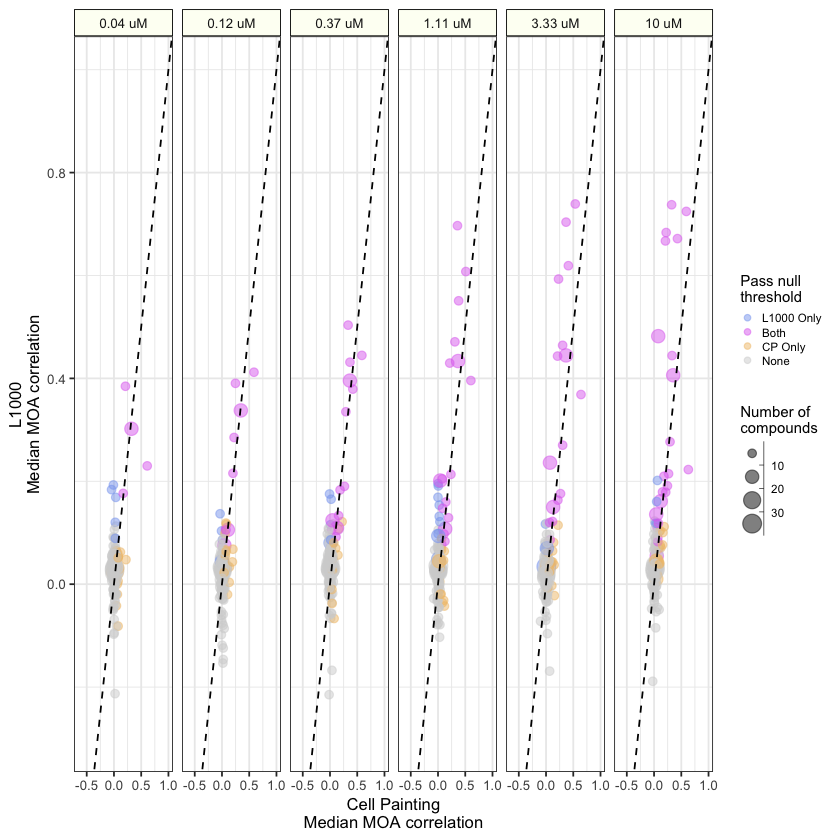

In [12]:
passing_colors <- unique(plot_ready_pm_df$moa_color_passing)
names(passing_colors) <- unique(plot_ready_pm_df$moa_color_passing)

passing_labels <- c("None", "L1000 Only", "CP Only", "Both")
names(passing_labels) <- unique(plot_ready_pm_df$moa_color_passing)

panel_b_gg <- (
    ggplot(plot_ready_pm_df, aes(x = `Cell Painting`, y = L1000))
    + geom_point(aes(size = avg_replicate_count, color = moa_color_passing), alpha = 0.5)
    + facet_grid("~dose")
    + figure_theme
    + scale_color_manual(
        "Pass null\nthreshold",
        values = passing_colors,
        labels = passing_labels
    )
    + scale_size_binned("Number of\ncompounds", range = c(0.5, 5))
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + xlim(c(-0.65, 1))
    + ylim(c(-0.3, 1))
    + xlab("Cell Painting\nMedian MOA correlation")
    + ylab("L1000\nMedian MOA correlation")
    + theme(legend.key.size = unit(0.3, 'cm'))
)

panel_b_gg

## Panel C - MOA percent matching summary

In [13]:
level4_results_dir <- file.path("../1.Data-exploration/Profiles_level4/results")

# Next, get the median scores and determine if they pass the threshold
cell_painting_comp_df <- load_median_correlation_scores(assay = "cellpainting", results_dir = level4_results_dir)
l1000_comp_df <- load_median_correlation_scores(assay = "l1000", results_dir = level4_results_dir)

cell_painting_pr_df <- load_percent_strong(assay = "cellpainting", results_dir = level4_results_dir)
l1000_pr_df <- load_percent_strong(assay = "l1000", results_dir = level4_results_dir)

pr_df <- dplyr::bind_rows(cell_painting_pr_df, l1000_pr_df)
pr_df$dose <- factor(pr_df$dose, levels = dose_order)

threshold_df <- pr_df %>%
    dplyr::filter(type == 'non_replicate') %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::summarise(threshold = quantile(replicate_correlation, 0.95))

significant_compounds_df <- cell_painting_comp_df %>%
    dplyr::left_join(l1000_comp_df, by = c("dose", "compound"), suffix = c("_cellpainting", "_l1000")) %>%
    tidyr::drop_na() %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "Cell Painting"), by = "dose") %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "L1000"), by = "dose", suffix = c("_cellpainting", "_l1000")) %>%
    dplyr::mutate(
        pass_cellpainting_thresh = median_replicate_score_cellpainting > threshold_cellpainting,
        pass_l1000_thresh = median_replicate_score_l1000 > threshold_l1000
    ) %>%
    dplyr::mutate(pass_both = pass_cellpainting_thresh + pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE)) %>%
    dplyr::select(compound, dose, median_replicate_score_cellpainting, median_replicate_score_l1000, pass_cellpainting_thresh, pass_l1000_thresh, pass_both)

Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”
Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”


In [14]:
pm_cellpainting_list <- load_percent_matching(assay = "cellpainting", results_dir = results_dir)
pm_l1000_list <- load_percent_matching(assay = "l1000", results_dir = results_dir)

cell_painting_pm_pval_df <- pm_cellpainting_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_pval_df <- pm_l1000_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pass_thresh_summary_df <- significant_compounds_df %>%
    dplyr::group_by(dose) %>%
    dplyr::mutate(
        num_pass_cellpainting = sum(pass_cellpainting_thresh),
        num_pass_l1000 = sum(pass_l1000_thresh),
        num_pass_both = sum(pass_both)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(dose, num_pass_cellpainting, num_pass_l1000, num_pass_both) %>%
    dplyr::distinct() %>%
    dplyr::mutate(
        unique_pass_cellpainting = num_pass_cellpainting - num_pass_both,
        unique_pass_l1000 = num_pass_l1000 - num_pass_both
    )

significant_moa_df <- cell_painting_pm_pval_df %>%
    dplyr::left_join(l1000_pm_pval_df, by = c("dose", "moa"), suffix = c("_cellpainting", "_l1000")) %>%
    tidyr::drop_na() %>%
    dplyr::mutate(
        pass_cellpainting_thresh = p_value_cellpainting < p_val_alpha_thresh,
        pass_l1000_thresh = p_value_l1000 < p_val_alpha_thresh
    ) %>%
    dplyr::select(moa, dose, pass_cellpainting_thresh, pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = pass_cellpainting_thresh + pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE))

pass_thresh_summary_moa_df <- significant_moa_df %>%
    dplyr::group_by(dose) %>%
    dplyr::mutate(
        num_pass_cellpainting = sum(pass_cellpainting_thresh),
        num_pass_l1000 = sum(pass_l1000_thresh),
        num_pass_both = sum(pass_both)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(dose, num_pass_cellpainting, num_pass_l1000, num_pass_both) %>%
    dplyr::distinct() %>%
    dplyr::mutate(
        unique_pass_cellpainting = num_pass_cellpainting - num_pass_both,
        unique_pass_l1000 = num_pass_l1000 - num_pass_both
    )

cell_painting_moa_rect <- pass_thresh_summary_moa_df %>%
    dplyr::select(dose, num_pass_cellpainting, unique_pass_cellpainting, num_pass_both) %>%
    dplyr::rename(c(ymax_bar = num_pass_cellpainting, unique_pass = unique_pass_cellpainting)) %>%
    dplyr::mutate(
        ymin_bar = 0,
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "Cell Painting",
        label_text_y = 2
    )

l1000_moa_rect <- pass_thresh_summary_moa_df %>%
    dplyr::mutate(ymax_bar = num_pass_cellpainting + unique_pass_l1000) %>%
    dplyr::select(dose, ymax_bar, unique_pass_cellpainting, unique_pass_l1000, num_pass_both) %>%
    dplyr::rename(c(ymin_bar = unique_pass_cellpainting, unique_pass = unique_pass_l1000)) %>%
    dplyr::mutate(
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "L1000",
        label_text_y = ymax_bar - 1.5
    )

full_moa_rect <- dplyr::bind_rows(cell_painting_moa_rect, l1000_moa_rect)

num_pass_both_moa_text <- full_moa_rect %>%
    dplyr::filter(assay == "Cell Painting") %>%
    dplyr::select(dose, xmin_bar, ymax_bar, num_pass_both) %>%
    dplyr::left_join(
        full_moa_rect %>%
            dplyr::filter(assay == "L1000") %>%
            dplyr::select(dose, ymin_bar) %>%
            dplyr::rename(c(ymin_l1000_bar = ymin_bar)),
        by = "dose"
    ) %>%
    dplyr::mutate(label_text_y = ymin_l1000_bar + num_pass_both / 2)

In [15]:
total_moas <- length(unique(significant_moa_df$moa))
total_moas

[1] 127

In [16]:
percentile_pass_moa_df <- pass_thresh_summary_moa_df %>%
    dplyr::mutate(
        num_pass_total = unique_pass_l1000 + unique_pass_cellpainting + num_pass_both,
        num_pass_percentile = paste("Total:\n", round(num_pass_total / total_moas, 2) * 100, "%")
    ) %>%
    dplyr::select(dose, num_pass_total, num_pass_percentile)

percentile_pass_moa_df

dose,num_pass_total,num_pass_percentile
<chr>,<int>,<chr>
0.04 uM,25,Total: 20 %
0.12 uM,26,Total: 20 %
0.37 uM,30,Total: 24 %
1.11 uM,39,Total: 31 %
3.33 uM,36,Total: 28 %
10 uM,41,Total: 32 %


In [17]:
# Prep legend order
full_moa_rect <- full_moa_rect %>%
    dplyr::add_row(
        dose = NA,
        ymax_bar = NA,
        unique_pass = NA,
        num_pass_both = NA,
        ymin_bar = NA,
        xmin_bar = NA,
        xmax_bar = NA,
        assay = "Both",
        label_text_y = NA
    ) %>%
    dplyr::left_join(percentile_pass_moa_df, by = "dose")

full_moa_rect$assay <- factor(full_moa_rect$assay, levels = c("L1000", "Both", "Cell Painting"))

Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


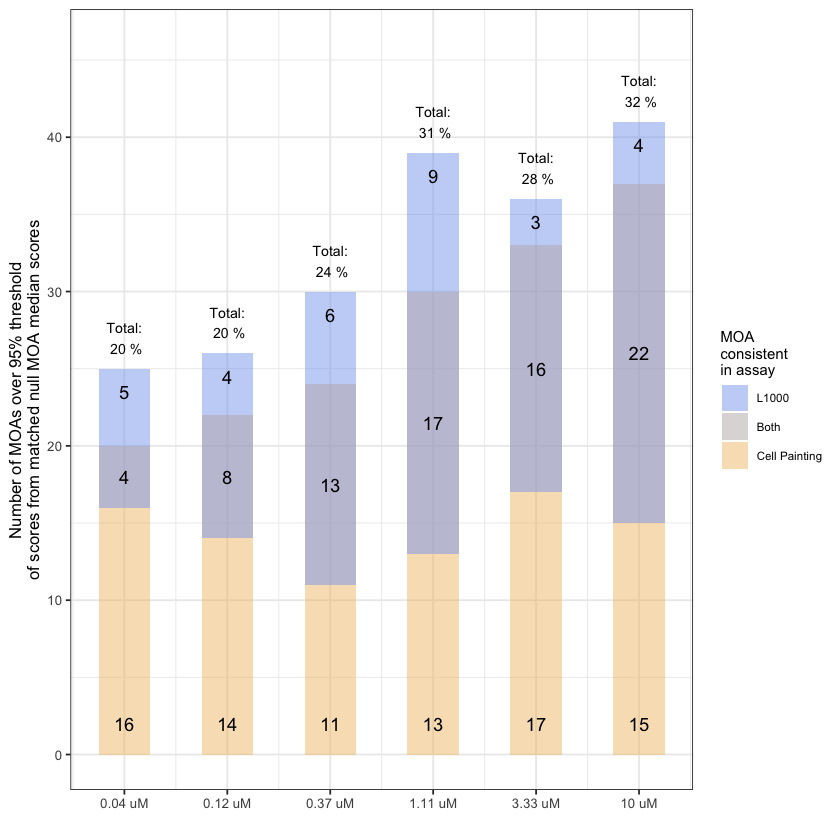

In [18]:
updated_assay_colors <- c(assay_colors, "Both" = "#BDB4B4") 

panel_c_gg <- (
    ggplot(full_moa_rect)
    + geom_rect(aes(fill = assay, ymin = ymin_bar, ymax = ymax_bar, xmin = xmin_bar, xmax = xmax_bar), alpha = 0.5)
    + geom_text(aes(x = xmin_bar + 0.5, y = label_text_y, label = unique_pass))
    + geom_text(data = num_pass_both_moa_text, aes(x = xmin_bar + 0.5, y = label_text_y, label = num_pass_both))
    # Select only L1000 below to not duplicate text
    + geom_text(
        data = full_moa_rect %>% dplyr::filter(assay == "L1000"),
        aes(x = xmin_bar + 0.5, y = ymax_bar + 2, label = num_pass_percentile),
        size = 3
    )
    + scale_fill_manual("MOA\nconsistent\nin assay", values = updated_assay_colors)
    + theme_bw()
    + figure_theme
    + scale_x_continuous(
        labels = num_pass_both_moa_text$dose,
        breaks = seq(0.5, length(num_pass_both_moa_text$dose) * 2, 2),
    )
    + ylab("Number of MOAs over 95% threshold\nof scores from matched null MOA median scores")
    + xlab("")
    + ylim(0, max(full_moa_rect$num_pass_total, na.rm = TRUE) + 5)
)

panel_c_gg

## Panel D - MOA examples

In [19]:
moa_count_filter <- 2

moa_match_df <- pm_df %>% dplyr::filter(pass_thresh)

consistent_match_moa_df <- moa_match_df %>%
    dplyr::group_by(assay, moa) %>%
    dplyr::tally() %>%
    dplyr::filter(n >= !!moa_count_filter) %>%
    reshape2::dcast(moa ~ assay, value.var = "n") %>%
    tidyr::replace_na(
        list(
            `Cell Painting` = 0,
            L1000 = 0
        )
    ) %>%
    dplyr::mutate(x_axis_location = "Cell Painting")

consistent_match_moa_df$x_axis_location[consistent_match_moa_df$L1000 > 0] = "L1000"
consistent_match_moa_df$x_axis_location[(consistent_match_moa_df$L1000 > 0 & consistent_match_moa_df$`Cell Painting` > 0)] = "Both"

# Define the order to plot the text
cell_painting_order <- consistent_match_moa_df %>%
    dplyr::filter(x_axis_location == "Cell Painting") %>%
    dplyr::arrange(`Cell Painting`, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

l1000_order <- consistent_match_moa_df %>%
    dplyr::filter(x_axis_location == "L1000") %>%
    dplyr::arrange(L1000, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

both_order <- consistent_match_moa_df %>%
    dplyr::mutate(both_count = (`Cell Painting` + L1000) / 2) %>%
    dplyr::filter(x_axis_location == "Both") %>%
    dplyr::arrange(both_count, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

full_moa_plot_order <- dplyr::bind_rows(cell_painting_order, l1000_order, both_order)

plot_ready_moa_text_df <- consistent_match_moa_df %>% dplyr::left_join(full_moa_plot_order, by = "moa") %>%
    dplyr::mutate(replicate_count = `Cell Painting` + L1000)

plot_ready_moa_text_df$x_axis_location <- factor(plot_ready_moa_text_df$x_axis_location, levels = c("Cell Painting", "Both", "L1000"))

print(length(unique(plot_ready_moa_text_df$moa)))
head(plot_ready_moa_text_df)

[1] 40


,moa,Cell Painting,L1000,x_axis_location,y_axis_location,replicate_count
,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1,acetylcholine receptor agonist,0,2,L1000,1,2
2,adenosine receptor antagonist,0,2,L1000,4,2
3,akt inhibitor,4,0,Cell Painting,40,4
4,alk tyrosine kinase receptor inhibitor,2,0,Cell Painting,1,2
5,androgen receptor agonist,6,4,Both,25,10
6,aromatase inhibitor,5,0,Cell Painting,46,5


In [20]:
moa_labels <- c("None", "L1000", "Cell Painting", "Both")

moa_colors <- unique(plot_ready_pm_df$moa_color_passing)
names(moa_colors) <- moa_labels
names(moa_labels) <- moa_labels

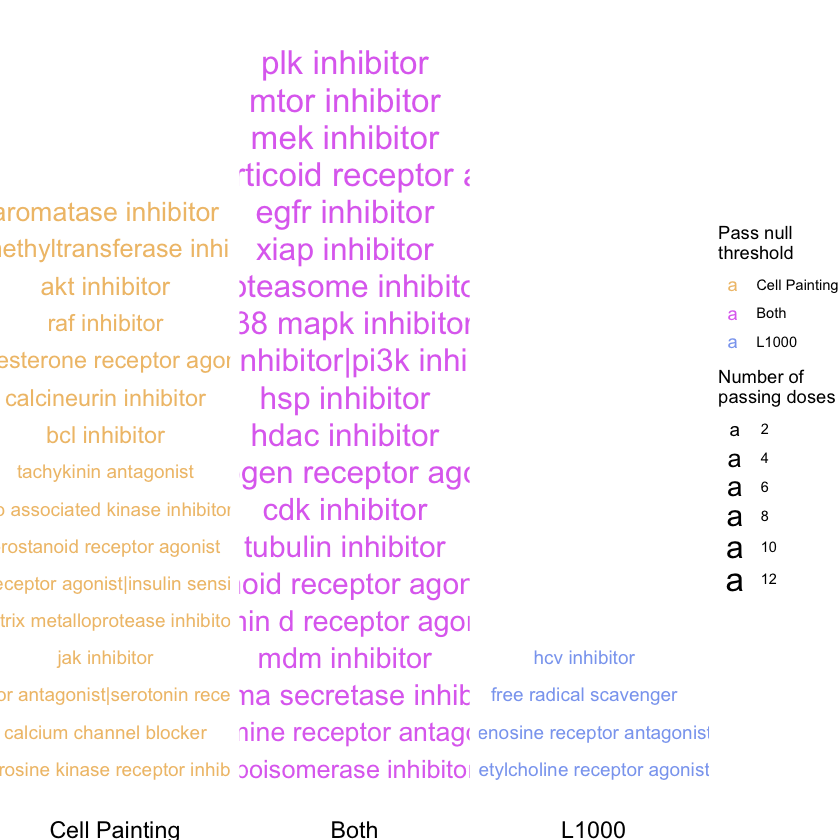

In [21]:
panel_d_gg <- (
    ggplot(plot_ready_moa_text_df, aes(y = y_axis_location, x = 0))
    + geom_text(aes(label = moa, color = x_axis_location, size = replicate_count))
    + facet_wrap("~x_axis_location", strip.position = "bottom")
    + theme_void()
    + theme(strip.text = element_text(size = 14))
    + scale_color_manual(
        "Pass null\nthreshold",
        values = moa_colors
    )
    + scale_size(
        "Number of\npassing doses",
        range = c(4, 7)
    )
    + xlim(-100, 120)
    + ylim(0, 60)
    + guides(color = guide_legend(order = 1))
)

panel_d_gg

## Compile figure 2

Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


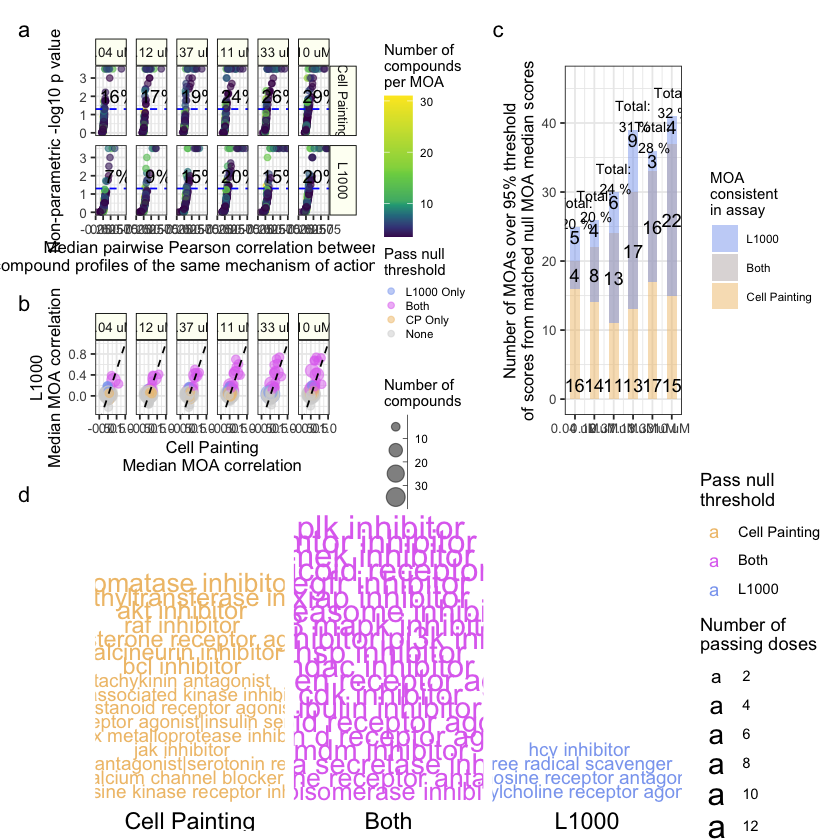

In [22]:
left_panel <- (panel_a_gg / panel_b_gg) + plot_layout(heights = c(2, 1))
top_panel <- (left_panel | panel_c_gg) + plot_layout(widths = c(2, 1))

figure_2_gg <- (
    top_panel / panel_d_gg
    + plot_layout(heights = c(2, 1.75))
    + plot_annotation(tag_levels = "a")
)

for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, figure_2_gg, width = 16, height = 11, dpi = 500)
}

figure_2_gg